In [1]:
!pip install biopython

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: qiskit-nature 0.5.0 has a non-standard dependency specifier qiskit-terra>=0.22.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of qiskit-nature or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


Structure exists: '/home/smohtash/ub/pdb1ubq.ent' 
Adjacency Matrix:
[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


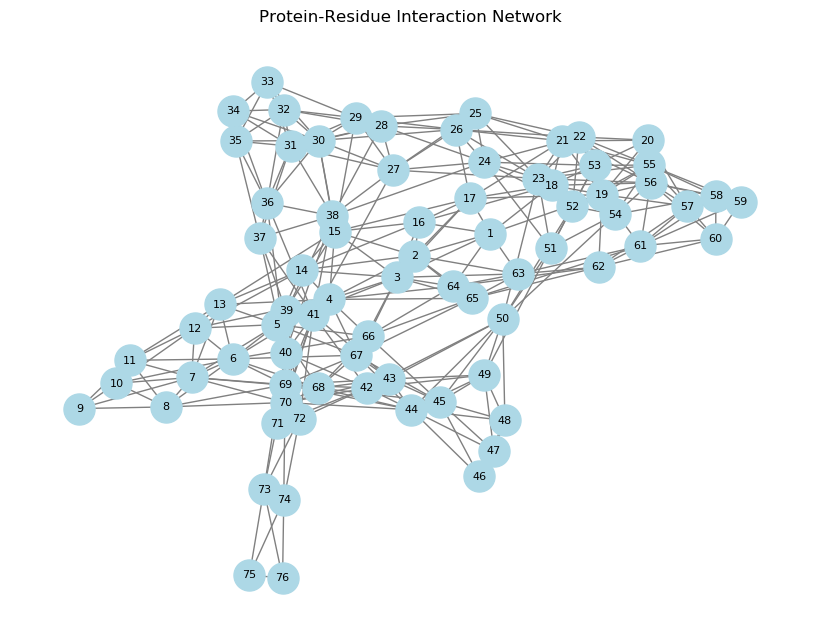

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from Bio import PDB
from Bio.PDB import PDBList

# Function to download PDB file from Protein Data Bank
def fetch_pdb(pdb_id):
    """Fetches a PDB file from the Protein Data Bank given a PDB ID."""
    pdbl = PDBList()
    pdb_file = pdbl.retrieve_pdb_file(pdb_id, file_format='pdb')
    return pdb_file

# Function to calculate the distance between two residues
def calculate_distance(residue_i, residue_j):
    """Calculates the Euclidean distance between the C-alpha atoms of two residues."""
    try:
        atom_i = residue_i["CA"].coord
        atom_j = residue_j["CA"].coord
        return np.linalg.norm(atom_i - atom_j)
    except KeyError:
        return float('inf')

# Function to construct a Protein-Residue Interaction Network
def construct_protein_residue_network(pdb_id, interaction_cutoff=8.0):
    """Constructs a residue interaction network from an online PDB file."""
    pdb_path = fetch_pdb(pdb_id)
    parser = PDB.PDBParser()
    structure = parser.get_structure("protein", pdb_path)
    G = nx.Graph()
    
    for chain in structure.get_chains():
        for residue_i in chain:
            for residue_j in chain:
                if residue_i != residue_j:
                    distance = calculate_distance(residue_i, residue_j)
                    if distance < interaction_cutoff:
                        G.add_edge(residue_i.get_id()[1], residue_j.get_id()[1])
    
    return G

# Example usage
pdb_id = "1UBQ"  # Example PDB ID
interaction_cutoff = 8.0  # Distance cutoff in Angstroms
G = construct_protein_residue_network(pdb_id, interaction_cutoff)

# Extract residue indices from the graph
residues = list(G.nodes())  # Extract nodes (residue IDs) from the network

# Function to create adjacency matrix
def create_adjacency_matrix(G, residues):
    """Creates an adjacency matrix from the interaction network."""
    residues = list(set(residues))  # Ensure uniqueness
    adjacency_matrix = nx.to_numpy_array(G, nodelist=residues)
    return adjacency_matrix


# Create adjacency matrix using the corrected residue list
adj_matrix = create_adjacency_matrix(G, residues)

print("Adjacency Matrix:")
print(adj_matrix)

# Save adjacency matrix to file
np.savetxt("adjacency_matrix.txt", adj_matrix, fmt="%d")

# Draw the network
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=8)
plt.title("Protein-Residue Interaction Network")
plt.show()


Top Residues by Eigenvector Centrality:
Residue 5: 0.2145
Residue 67: 0.2035
Residue 4: 0.2007
Residue 3: 0.1959
Residue 69: 0.1953
Residue 6: 0.1929
Residue 68: 0.1816
Residue 66: 0.1654
Residue 44: 0.1607
Residue 43: 0.1583


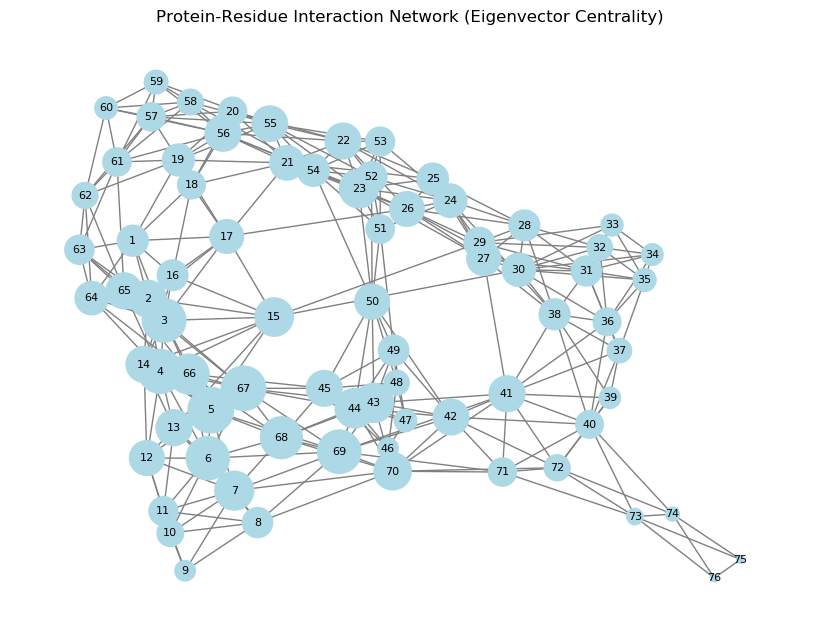

In [3]:
def compute_eigenvector_centrality(G):
    """
    Computes the eigenvector centrality of the protein-residue interaction network.

    Parameters:
    G (networkx.Graph): The protein-residue interaction network.

    Returns:
    dict: A dictionary of nodes with their eigenvector centrality scores.
    """
    try:
        centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-6)
        return centrality
    except nx.NetworkXError as e:
        print(f"Eigenvector centrality calculation failed: {e}")
        return None

# Compute eigenvector centrality
eigenvector_centrality = compute_eigenvector_centrality(G)

# Print top residues by eigenvector centrality
print("Top Residues by Eigenvector Centrality:")
sorted_centrality = sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)
for residue, score in sorted_centrality[:10]:  # Print top 10 residues
    print(f"Residue {residue}: {score:.4f}")

# Visualization: Draw network with node sizes based on eigenvector centrality
plt.figure(figsize=(8, 6))
node_sizes = [5000 * eigenvector_centrality[node] for node in G.nodes()]  # Scale node sizes
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray',
        node_size=node_sizes, font_size=8)
plt.title("Protein-Residue Interaction Network (Eigenvector Centrality)")
plt.show()


In [4]:
# import numpy as np
# import pennylane as qml
# from pennylane import numpy as pnp

# # Define adjacency matrix A for a sample graph (example)
# A = adj_matrix
# n = A.shape[0]  # Number of nodes
# d = np.sum(A, axis=1)  # Degree sequence
# d_norm = d / np.linalg.norm(d)  # Normalized degree vector
# d_matrix = np.outer(d_norm, d_norm)  # d̂d̂^T matrix

# # Define penalty parameters
# P0 = 1 / np.sqrt(n)
# P1 = tau * n

# def construct_qubo(A, P0, P1, tau):
#     """Constructs QUBO matrix Q."""
#     n = A.shape[0]
#     C = (1 - 2 * tau) * np.eye(n) + np.ones((n, n)) - np.eye(n)
#     Q = -P0 * (A @ d_matrix @ A + A @ d_matrix @ A @ A) + P1 * C
#     return Q

# # Define tau (number of most influential nodes to identify)
# tau = 1
# Q = construct_qubo(A, P0, P1, tau)

# # Convert QUBO to cost Hamiltonian
# coeffs = []
# ops = []
# for i in range(n):
#     coeffs.append(Q[i, i])
#     ops.append(qml.PauliZ(i))
# for i in range(n):
#     for j in range(i + 1, n):
#         coeffs.append(Q[i, j])
#         ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
# cost_hamiltonian = qml.Hamiltonian(coeffs, ops)

# # Define mixer Hamiltonian
# mixer_hamiltonian = qml.Hamiltonian(
#     [1.0] * n, [qml.PauliX(i) for i in range(n)]
# )

# # Define QAOA circuit with sampling enabled
# dev = qml.device("default.qubit", wires=n, shots=1024)

# @qml.qnode(dev)
# def qaoa_circuit(params):
#     """QAOA circuit for optimizing the QUBO problem."""
#     for i in range(n):
#         qml.Hadamard(wires=i)
#     for p in range(len(params) // 2):
#         qml.templates.ApproxTimeEvolution(cost_hamiltonian, params[2 * p], 1)
#         qml.templates.ApproxTimeEvolution(mixer_hamiltonian, params[2 * p + 1], 1)
#     return qml.expval(cost_hamiltonian)

# # Define cost function for optimization
# def cost_function(params):
#     return qaoa_circuit(params)

# # Optimize using classical method
# opt = qml.GradientDescentOptimizer(stepsize=0.1)
# params = pnp.random.uniform(-np.pi, np.pi, size=(6,), requires_grad=True)  # For p=3
# for _ in range(100):
#     params = opt.step(cost_function, params)

# # Print results
# print("Optimized parameters:", params)
# print("Final cost value:", cost_function(params))


In [5]:
# import numpy as np

# # Run the optimized QAOA circuit
# binary_solution = qaoa_circuit(params)

# # Ensure binary_solution is an array
# binary_solution = np.array(binary_solution)

# # If it's a scalar (0-D array), reshape it into a 1-D array
# if binary_solution.ndim == 0:
#     binary_solution = np.array([binary_solution])

# # Debugging: Print the raw output
# print("Raw output from QAOA circuit:", binary_solution)
# print("Binary solution shape:", binary_solution.shape)

# # Convert -1,1 Pauli-Z output to binary (0,1)
# binary_solution = [(1 if x == -1 else 0) for x in binary_solution.flatten()]

# # Extract influential nodes
# selected_nodes = [i for i, value in enumerate(binary_solution) if value == 1]

# # Print the extracted nodes
# print("Most influential nodes:", selected_nodes)


In [6]:
pip install dwave-ocean-sdk


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: qiskit-nature 0.5.0 has a non-standard dependency specifier qiskit-terra>=0.22.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of qiskit-nature or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [7]:
import networkx as nx
import numpy as np
from dimod import BinaryQuadraticModel, SimulatedAnnealingSampler

# Define constants

A = adj_matrix
n = len(A)
tau = 5  # Desired number of top nodes
P0 = 1 / np.sqrt(n)  # Based on the paper
P1 = 10 * n          # Stronger penalty to enforce the constraint

def calculate_d_hat(adj_matrix):
    d = np.sum(adj_matrix, axis=1)
    d_hat = d / np.linalg.norm(d)
    return d_hat

d_hat = calculate_d_hat(A)

# Construct C matrix
I = np.eye(n)
U = np.ones((n, n)) - I
C = (1 - 2 * tau) * I + U

# Construct Q matrix
Q = -P0 * (A @ np.outer(d_hat, d_hat) @ A) \
    - P0 * (A @ np.outer(d_hat, d_hat) @ A @ A) \
    + P1 * C

# Convert to BQM
bqm = BinaryQuadraticModel.from_numpy_matrix(Q)

# Simulated annealing
sampler = SimulatedAnnealingSampler()
response = sampler.sample(bqm, num_reads=10000, beta_range=(0.1, 4.0))

# Filter solutions with exactly tau selected nodes
valid_solutions = []
for sample, energy in response.data(['sample', 'energy']):
    if sum(sample.values()) == tau:
        valid_solutions.append((sample, energy))

if valid_solutions:
    best_sample, best_energy = min(valid_solutions, key=lambda x: x[1])
    top_nodes = [node + 1 for node, val in best_sample.items() if val == 1]

    print("Best valid sample:", best_sample)
    print("Energy:", best_energy)
    print("Top nodes:", top_nodes)
else:
    print("No valid solution with exactly τ selected nodes.")



/tmp/ipykernel_125590/628357712.py:31: DeprecationWarning: BQM.from_numpy_matrix(M) is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use BQM(M, "BINARY") instead.
  bqm = BinaryQuadraticModel.from_numpy_matrix(Q)


Best valid sample: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0}
Energy: -19061.8748625078
Top nodes: [66, 67, 68, 69, 70]


Top Residues by Estrada Centrality:
Residue 5: 844.8052
Residue 4: 773.6491
Residue 23: 755.6820
Residue 3: 746.7237
Residue 6: 730.5632
Residue 67: 722.5564
Residue 69: 722.0195
Residue 56: 663.2666
Residue 55: 640.1370
Residue 68: 616.1906


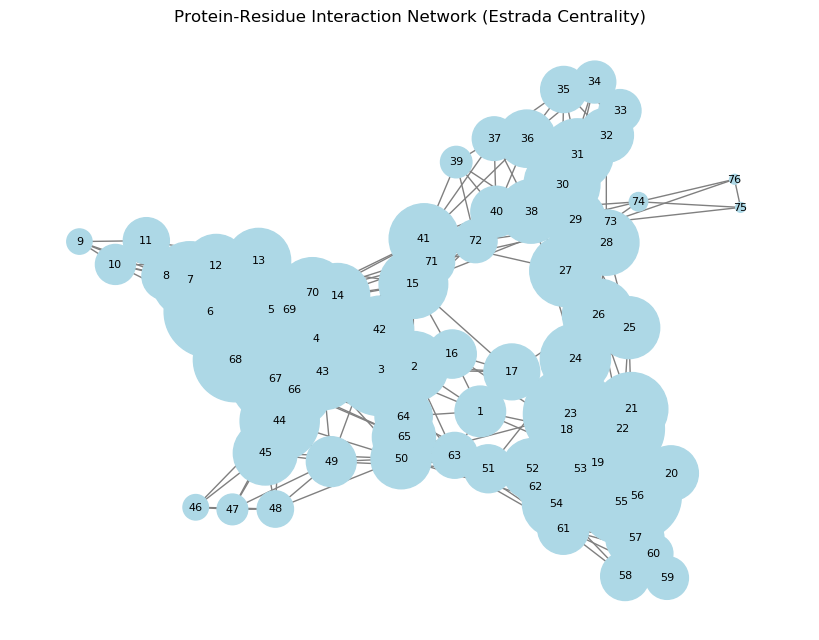

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import expm

def compute_estrada_centrality_manual(G):
    """
    Computes Estrada centrality by evaluating the diagonal of the matrix exponential of A.

    Parameters:
    G (networkx.Graph): The protein-residue interaction network.

    Returns:
    dict: A dictionary of nodes with their Estrada centrality scores.
    """
    A = nx.to_numpy_array(G)  # Adjacency matrix
    E = expm(A)               # Matrix exponential e^A
    estrada_scores = np.diag(E)  # Extract diagonal elements

    return {node: estrada_scores[i] for i, node in enumerate(G.nodes())}

# --- Compute Estrada Centrality ---
estrada_centrality = compute_estrada_centrality_manual(G)

# --- Print Top Residues by Estrada Centrality ---
print("Top Residues by Estrada Centrality:")
sorted_estrada = sorted(estrada_centrality.items(), key=lambda item: item[1], reverse=True)
for residue, score in sorted_estrada[:10]:  # Top 10
    print(f"Residue {residue}: {score:.4f}")

# --- Visualization: Network Colored by Estrada Centrality ---
plt.figure(figsize=(8, 6))
node_sizes = [5000 * estrada_centrality[node] / max(estrada_centrality.values()) for node in G.nodes()]
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray',
        node_size=node_sizes, font_size=8)
plt.title("Protein-Residue Interaction Network (Estrada Centrality)")
plt.show()



In [ ]:
import networkx as nx
import numpy as np
from dimod import BinaryQuadraticModel, SimulatedAnnealingSampler

# --- Input: Adjacency matrix ---
A = adj_matrix  # Use your preloaded or computed adjacency matrix here
n = len(A)
tau = 1
P0 = 1 / np.sqrt(n)
P1 = 100 * n

# --- Step 1: Degree normalization ---
def calculate_d_hat(adj_matrix):
    d = np.sum(adj_matrix, axis=1)
    d_hat = d / np.linalg.norm(d)
    return d_hat

d_hat = calculate_d_hat(A)

# --- Step 2: Construct matrix exponential approximation E = I + A + 0.5 A^2 + (1/6) A^3 ---
A2 = A @ A
A3 = A2 @ A
E = np.eye(n) + A + 0.5 * A2 + (1/6) * A3

# --- Step 3: Build low-rank Estrada projection: E * d_hat * d_hat^T * E ---
d_outer = np.outer(d_hat, d_hat)
projection = E @ d_outer @ E  # Rank-1 projection of spectral walk weights

# --- Step 4: Constraint matrix ---
I = np.eye(n)
U = np.ones((n, n)) - I
C = (1 - 2 * tau) * I + U

# --- Step 5: Final QUBO matrix ---
Q = -P0 * projection + P1 * C

# --- Step 6: Convert QUBO to BQM ---
bqm = BinaryQuadraticModel.from_numpy_matrix(Q)

# --- Step 7: Simulated annealing to solve QUBO ---
sampler = SimulatedAnnealingSampler()
response = sampler.sample(bqm, num_reads=10000, beta_range=(0.1, 4.0))

# --- Step 8: Filter valid τ-sparse solutions ---
valid_solutions = []
for sample, energy in response.data(['sample', 'energy']):
    if sum(sample.values()) == tau:
        valid_solutions.append((sample, energy))

if valid_solutions:
    best_sample, best_energy = min(valid_solutions, key=lambda x: x[1])
    top_nodes = [node + 1 for node, val in best_sample.items() if val == 1]
    print("Best valid sample:", best_sample)
    print("Energy:", best_energy)
    print("Top nodes (Estrada centrality):", top_nodes)
else:
    print("No valid solution with exactly τ selected nodes.")


/tmp/ipykernel_125590/3288079529.py:38: DeprecationWarning: BQM.from_numpy_matrix(M) is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use BQM(M, "BINARY") instead.
  bqm = BinaryQuadraticModel.from_numpy_matrix(Q)
